# Data preparation

In [1]:
#importing initial libraries 

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.layers import Dense, LSTM, Bidirectional, GRU, SimpleRNN
from keras.models import Sequential
import nltk
import re
import tqdm


2025-02-01 20:32:16.528270: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-01 20:32:16.682658: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-01 20:32:16.682687: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-01 20:32:16.711077: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-01 20:32:16.716118: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# import dataset 
path = '/home/adnane/Desktop/etude_linux/DeepLearning/benchmark/ready_data.csv'
df = pd.read_csv(path)
df.head()

,comment,label
0,لا مقارنة بين منظومة إس 400 و منظومة ثااد\nمنظ...,negative
1,بعد هذه الخطوة انتظروا دعم روسيا و الصين لسياد...,negative
2,* لا يمكن أن يكون حل سياسي دون حرب ، إذن لا بد...,negative
3,واش حنا ما كاين غير شراء و اقتناء، فين الاستثم...,neutral
4,بالأمس القريب كان المغاربة في حديثهم عن أسلحة ...,negative


In [3]:
df.shape

(97107, 2)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97107 entries, 0 to 97106
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  97107 non-null  object
 1   label    97107 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [5]:
df.label.value_counts()

label
negative    47635
positive    24905
neutral     24567
Name: count, dtype: int64

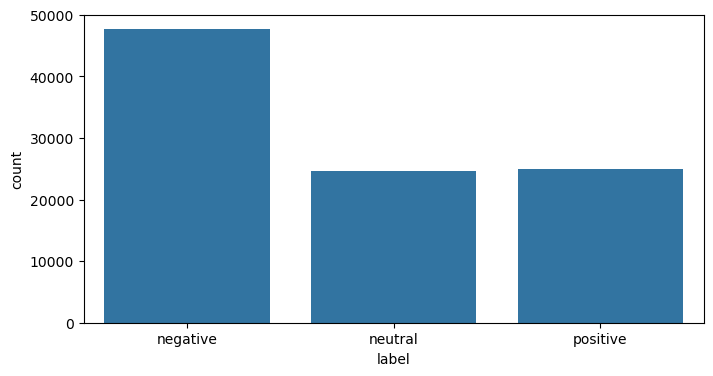

In [6]:
import seaborn as sns

plt.figure(figsize=(8,4))
sns.countplot(x='label', data=df);

In [7]:
#print the number of null values in each column
df.isnull().sum()

comment    0
label      0
dtype: int64

In [8]:
#print the number of duplicated values 
df.duplicated().sum()

9839

In [9]:
#print the rows which are duplicated
df[df['comment'].duplicated() == True]

,comment,label
319,الحكومة الحالية إيجابية وواعدة بالتقدم في مسار...,positive
320,لا يمكننا نكران ان الحكومة تشتغل على خلق مجلس ...,neutral
321,الحكومة الحالية تبرز إرادة سياسية إصلاحية قوية...,neutral
336,اللهم دم العز و النصر و التمكين و الصحة و السل...,positive
432,نحن على تقة بحكومتنا انها ستعمل بكل جدية من اج...,positive
...,...,...
96160,و الله ما لا حظتُه هو أنني عندما أكون في أوروب...,negative
96161,خصوصا التشجيع على الاندماج و التسامح و أننا ب...,positive
96162,جميل هذه المبادرة ان يتعلم المغربي اصوله الدين...,positive
96163,الدين مسألة شخصية بين الإنسان و ربه يجب ان يفص...,neutral


In [10]:
df[df['comment'] == df.iloc[76]['comment']]

,comment,label
76,تشبث غريق بغريق. دويلة تونس هي الدوزيام كرغول....,neutral


In [11]:
#removing duplicated values
index = df[df['comment'].duplicated() == True].index
df.drop(index, axis = 0, inplace = True)

In [12]:
df.label.value_counts()


label
negative    44575
neutral     21109
positive    17472
Name: count, dtype: int64

# Data Preprocessing :

## stop words definition :

In [13]:
# !pip install Arabic-Stopwords

import arabicstopwords.arabicstopwords as stp #more range of arabic stop words


In [14]:
from nltk.corpus import stopwords

#are there any stop words in the data?
arabic_stopwords = stopwords.words("arabic")
len(arabic_stopwords)

754

In [15]:
df['stop_words'] = df['comment'].apply(lambda x: len(set(x.split()) & set(arabic_stopwords)))

In [16]:
df.stop_words.value_counts()

stop_words
3     9196
4     9067
2     8571
5     8052
6     7092
7     6049
1     6038
8     5127
9     4132
10    3346
0     3095
11    2790
12    2294
13    1753
14    1463
15    1126
16     947
17     703
18     529
19     432
20     346
21     266
22     193
23     154
24     118
25      73
26      62
27      48
28      39
29      20
30      12
31       7
32       6
33       3
34       3
42       1
37       1
41       1
38       1
Name: count, dtype: int64

In [17]:
df.head()

,comment,label,stop_words
0,لا مقارنة بين منظومة إس 400 و منظومة ثااد\nمنظ...,negative,4
1,بعد هذه الخطوة انتظروا دعم روسيا و الصين لسياد...,negative,5
2,* لا يمكن أن يكون حل سياسي دون حرب ، إذن لا بد...,negative,11
3,واش حنا ما كاين غير شراء و اقتناء، فين الاستثم...,neutral,4
4,بالأمس القريب كان المغاربة في حديثهم عن أسلحة ...,negative,3


In [18]:
# longest comment in data 
max_words = df['comment'].apply(lambda x: len(x.split())).max()
print('The longest comment in the data has {} words'.format(max_words))

The longest comment in the data has 219 words


In [19]:
avg_words = df['comment'].apply(lambda x: len(x.split())).mean()
print(avg_words)

37.895726105151766


while we have small comments lenth, and specially working with arabic comments,we choose to not removing stop words which carry subtle sentiment in certain contexts. For example:
"ليس جيدًا" ("not good") has a negative sentiment, and "ليس" (a stop word) is essential for understanding the sentiment.
s

Several natural language processing (NLP) tools for Arabic in Python, such as the Natural Language Toolkit (NLTK), PyArabic, and arabic_nlp.
When processing Arabic comments for sentiment analysis or other NLP tasks, we should follow a logical sequence to ensure optimal results. 
- Tokenization 
- Normalization
- Stemming or Lemmatization
-  Part-of-Speech (POS) Tagging
- Named Entity Recognition (NER)
- word Embeddings

| Task                  | Best Libraries/Tools | Why?                                     |
|-----------------------|----------------------|------------------------------------------|
| Tokenization          | Camel Tools          | Arabic-specific, better morphology handling. |
| Normalization         | Pyarabic             | Customizable and reliable for Arabic.    |
| Stemming/Lemmatization| Camel Tools          | Handles rich Arabic morphology well.     |
| POS Tagging           | NLTK         | Accurate for Arabic grammar.             |
| NER                   | Camel Tools          | Specialized for Arabic entities.         |
| Word Embeddings       | AraBERT              | Pre-trained Arabic embeddings.           |


In [20]:
# remove column stop_words
df.drop('stop_words', axis = 1, inplace = True)
df.head()

,comment,label
0,لا مقارنة بين منظومة إس 400 و منظومة ثااد\nمنظ...,negative
1,بعد هذه الخطوة انتظروا دعم روسيا و الصين لسياد...,negative
2,* لا يمكن أن يكون حل سياسي دون حرب ، إذن لا بد...,negative
3,واش حنا ما كاين غير شراء و اقتناء، فين الاستثم...,neutral
4,بالأمس القريب كان المغاربة في حديثهم عن أسلحة ...,negative


In [21]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('arabic')
nltk.download('punkt')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/adnane/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Error loading arabic: Package 'arabic' not found in index
[nltk_data] Downloading package punkt to /home/adnane/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 1- Tokenization

In [22]:
from nltk.tokenize import word_tokenize
from transformers import AutoTokenizer, AutoModel

from pyarabic.araby import strip_tashkeel, normalize_hamza, strip_tatweel
from camel_tools.tokenizers.word import simple_word_tokenize

/home/adnane/anaconda3/envs/tf2.15_gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
from tqdm import tqdm
tokenizer = simple_word_tokenize 
def tokenize(df):
    tqdm.pandas(desc="Tokenizing")
    df['tokens'] = df['comment'].progress_apply(lambda x: simple_word_tokenize(x))
    return df


In [24]:

def normalizeArabic(text):
    text = " ".join(text)  # Join tokens back into a single string
    text = text.strip()  # Remove leading and trailing whitespaces
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    
    # Remove repetitions
    text = re.sub("[إأٱآا]", "ا", text)
    text = text.replace("وو", "و")
    text = text.replace("يي", "ي")
    text = text.replace("ييي", "ي")
    text = text.replace("اا", "ا")

    # Remove extra whitespace
    text = re.sub("\s+", " ", text)
    
    # Normalize Arabic text
    text = strip_tashkeel(text)  # Remove diacritics
    text = normalize_hamza(text)  # Normalize Hamza forms
    text = strip_tatweel(text)  # Remove elongation
    
    # Remove digits
    text = "".join([i for i in text if not i.isdigit()])
    
    return text.split()  # Return the normalized text as tokens

def normalize_arabic_column(df, column_name='tokens'):
    tqdm.pandas(desc="Normalizing Arabic Text")
    df['normalized_comment'] = df[column_name].progress_apply(normalizeArabic)
    return df

## NER (named entity recognition)

In [25]:
from camel_tools.ner import NERecognizer
import ast

def ner_arabic_camel(df, column_name='normalized_comment'):
    # Initialize the NER model
    ner = NERecognizer.pretrained()
    
    def extract_entities(text):
        # Convert string representation of list to actual list
        if isinstance(text, str):
            try:
                # Handle string representation of list
                tokens = ast.literal_eval(text)
            except:
                # If not a list representation, split by space
                tokens = text.split()
        elif isinstance(text, list):
            tokens = text
        else:
            return []
        
        # Get NER predictions
        entities = ner.predict_sentence(tokens)
        return [(token, label) for token, label in zip(tokens, entities)]
    
    # Process only first row for testing
    first_row = df[column_name].iloc[0]
    print("\nProcessing first row for testing:")
    print("-" * 50)
    result = extract_entities(first_row)
    print("\nNER Result:")
    print(result)
    
    # # Ask for confirmation to process more data
    # user_input = input("\nDo you want to process more data? (yes/no): ")
    
    # if user_input.lower() == 'yes':
    #     # Process first 5 rows
    #     sample_df = df.head(5).copy()
    #     print("\nProcessing first 5 rows...")
    #     tqdm.pandas(desc="Extracting Named Entities")
    #     sample_df['ner'] = sample_df[column_name].progress_apply(extract_entities)
    #     return sample_df
    # else:
    #     print("\nProcessing stopped after first row.")
    #     return pd.DataFrame({'ner': [result]})

    # Process all rows
    tqdm.pandas(desc="Extracting Named Entities")
    df['ner'] = df[column_name].progress_apply(extract_entities)
    return df


## Part-of-Speech (POS) Tagging with NLTK


In [26]:
from camel_tools.disambig.mle import MLEDisambiguator
from camel_tools.tagger.default import DefaultTagger

In [27]:
def pos_tag_arabic_nltk(df, column_name='normalized_comment'):
    """Process POS tagging for Arabic text and add as dataframe column"""
    def process_text(text):
        # Handle input text (similar to NER function)
        if isinstance(text, str):
            try:
                tokens = ast.literal_eval(text)
            except:
                tokens = text.split()
        elif isinstance(text, list):
            tokens = text
        else:
            return []
        
        # Perform POS tagging
        tagged = nltk.pos_tag(tokens)
        return [(token, tag) for token, tag in tagged]
    
    # Process first 5 rows for preview
    print("\nProcessing first 5 rows for POS tagging:")
    print("-" * 50)
    for i in range(min(5, len(df))):
        result = process_text(df[column_name].iloc[i])
        print(f"\nRow {i+1} POS Tagging Result:")
        print(result)
    
    # Ask for confirmation
    user_input = input("\nContinue processing all rows? (y/n): ")
    if user_input.lower() != 'y':
        return df
    
    # Process all rows
    tqdm.pandas(desc="Performing POS Tagging")
    df['pos_tags'] = df[column_name].progress_apply(process_text)
    return df


## Stemming with nltk

In [28]:
from nltk.stem.isri import ISRIStemmer

def stem_arabic_nltk(df, column_name='normalized_comment'):
    """Process stemming for Arabic text and add as dataframe column"""
    stemmer = ISRIStemmer()
    
    def process_text(text):
        # Handle input text (similar to NER function)
        if isinstance(text, str):
            try:
                tokens = ast.literal_eval(text)
            except:
                tokens = text.split()
        elif isinstance(text, list):
            tokens = text
        else:
            return []
        
        # Perform stemming
        stemmed = [stemmer.stem(token) for token in tokens]
        return [(token, stemmed_token) for token, stemmed_token in zip(tokens, stemmed)]
    
    # Process first 5 rows for preview
    print("\nProcessing first 5 rows for stemming:")
    print("-" * 50)
    for i in range(min(5, len(df))):
        result = process_text(df[column_name].iloc[i])
        print(f"\nRow {i+1} Stemming Result:")
        print(result)
    
    # Ask for confirmation
    user_input = input("\nContinue processing all rows? (y/n): ")
    if user_input.lower() != 'y':
        return df
    
    # Process all rows
    tqdm.pandas(desc="Performing Stemming")
    df['stemmed'] = df[column_name].progress_apply(process_text)
    return df

## Lemmatization with nltk

In [29]:
from camel_tools.morphology.database import MorphologyDB
from camel_tools.morphology.analyzer import Analyzer
import pandas as pd
from tqdm import tqdm

# Initialize the Arabic lemmatizer using camel_tools
arabic_lemmatizer = Analyzer(MorphologyDB.builtin_db('calima-msa-r13'))

def lemmatize_arabic_camel_tools(df, column_name='normalized_comment'):
    """Process lemmatization for Arabic text using camel_tools and add as dataframe column"""

    def process_text(text):
        # Handle input text
        if isinstance(text, str):
            tokens = text.split()  # Split text into tokens
        elif isinstance(text, list):
            tokens = text  # Use the list directly
        else:
            return []  # Return an empty list for unsupported types

        # Perform lemmatization using camel_tools Analyzer
        lemmatized = []
        for token in tokens:
            analyses = arabic_lemmatizer.analyze(token)
            if analyses:
                # Get the lemma from the first analysis (most likely analysis)
                lemma = analyses[0]['lex']
                lemmatized.append(lemma)
            else:
                # If no analysis is found, keep the original token
                lemmatized.append(token)

        # Return a list of tuples: (original_token, lemmatized_token)
        return list(zip(tokens, lemmatized))

    # Process first 5 rows for preview
    print("\nProcessing first 5 rows for lemmatization:")
    print("-" * 50)
    for i in range(min(5, len(df))):
        result = process_text(df[column_name].iloc[i])
        print(f"\nRow {i+1} Lemmatization Result:")
        print(result)

    # Ask for confirmation
    user_input = input("\nContinue processing all rows? (y/n): ")
    if user_input.lower() != 'y':
        return df  # Exit early if the user does not confirm

    # Process all rows with a progress bar
    tqdm.pandas(desc="Performing Lemmatization")
    df['lemmatized'] = df[column_name].progress_apply(process_text)

    return df

In [30]:
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
import ast
from tqdm import tqdm

def remove_punctuation(text):
    """
    Remove punctuation from Arabic text.
    """
    # Define Arabic punctuation marks
    arabic_punctuation = r'[،؛؟.!"\'()\[\]{}<>:;،؟]'
    return re.sub(arabic_punctuation, ' ', text)

def safe_convert_lemmas(lemma_str):
    """
    Safely convert string representation of lemmas to actual list of lemmas (second element in each tuple).
    """
    try:
        lemmas = ast.literal_eval(lemma_str)  # Convert string to list of tuples
        if isinstance(lemmas, list):
            # Extract the second element (lemma) from each tuple if the tuple has at least 2 elements
            return [item[1] for item in lemmas if len(item) >= 2]
        return []
    except:
        return []

def custom_tokenizer(text):
    """
    Custom tokenizer to split text into lemmas based on spaces.
    """
    return text.split()

def calculate_bow_and_tfidf(df, lemmatized_column='lemmatized', max_features=50):
    """
    Final fixed version with proper DataFrame handling.
    """
    
    # 1. Convert string lemmas to actual lists of lemmas
    tqdm.pandas(desc="Converting lemma strings")
    df['clean_lemmas'] = df[lemmatized_column].progress_apply(safe_convert_lemmas)
    
    # 2. Create lemma text column by joining the lemmas into a single string
    df['lemma_text'] = df['clean_lemmas'].apply(
        lambda x: ' '.join(x) if isinstance(x, list) else ''
    )
    
    # 3. Remove punctuation from the lemma text
    df['lemma_text'] = df['lemma_text'].apply(remove_punctuation)
    
    # 4. Filter out rows with empty lemma text and reset index
    df = df[df['lemma_text'].str.strip() != ''].copy()
    df = df.reset_index(drop=True)
    
    # 5. Create vectorizers with custom tokenizer
    bow_vectorizer = CountVectorizer(
        max_features=max_features,
        tokenizer=custom_tokenizer,  # Use custom tokenizer
        token_pattern=None  # Disable default token pattern
    )
    tfidf_vectorizer = TfidfVectorizer(
        max_features=max_features,
        tokenizer=custom_tokenizer,  # Use custom tokenizer
        token_pattern=None  # Disable default token pattern
    )
    
    # 6. Generate matrices
    bow_matrix = bow_vectorizer.fit_transform(df['lemma_text'])
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['lemma_text'])
    
    # 7. Create DataFrames with proper text reference
    def create_feature_df(matrix, vectorizer):
        feature_df = pd.DataFrame.sparse.from_spmatrix(
            matrix, 
            columns=vectorizer.get_feature_names_out()
        )
        feature_df.insert(0, 'Original Text', df['lemma_text'].values)
        return feature_df
    
    bow_df = create_feature_df(bow_matrix, bow_vectorizer)
    tfidf_df = create_feature_df(tfidf_matrix, tfidf_vectorizer)
    
    # 8. Format output
    print("\n═"*40 + " BOW " + "═"*40)
    print(bow_df.head())
    
    print("\n═"*40 + " TF-IDF " + "═"*40)
    print(tfidf_df.head().style.format("{:.3f}"))
    
    return bow_df, tfidf_df, (bow_vectorizer, tfidf_vectorizer)

## Word Frequency (BoW & TF-IDF)

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

def visualize_and_display_results(bow_df, tfidf_df, vectorizers, top_n=10):
    """
    Visualize and display the results of BOW and TF-IDF matrices with Arabic support.
    
    Parameters:
    - bow_df: DataFrame containing the Bag of Words (BOW) matrix.
    - tfidf_df: DataFrame containing the TF-IDF matrix.
    - vectorizers: Tuple containing the BOW and TF-IDF vectorizers.
    - top_n: Number of top features to display in visualizations and lists.
    """
    
    # Extract feature names from the vectorizers
    bow_vectorizer, tfidf_vectorizer = vectorizers
    bow_features = bow_vectorizer.get_feature_names_out()
    tfidf_features = tfidf_vectorizer.get_feature_names_out()
    
    # Sum the counts for BOW and TF-IDF to get the most important features
    bow_sum = bow_df.drop(columns=['Original Text']).sum().sort_values(ascending=False)
    tfidf_sum = tfidf_df.drop(columns=['Original Text']).sum().sort_values(ascending=False)
    
    # Plot the top N features for BOW
    plt.figure(figsize=(12, 6))
    sns.barplot(x=bow_sum.head(top_n).values, y=bow_sum.head(top_n).index, palette="viridis")
    plt.title(f'Top {top_n} BOW Features')
    plt.xlabel('Frequency')
    plt.ylabel('Features')
    plt.tight_layout()  # Ensure proper layout for Arabic text
    plt.show()
    
    # Plot the top N features for TF-IDF
    plt.figure(figsize=(12, 6))
    sns.barplot(x=tfidf_sum.head(top_n).values, y=tfidf_sum.head(top_n).index, palette="magma")
    plt.title(f'Top {top_n} TF-IDF Features')
    plt.xlabel('TF-IDF Score')
    plt.ylabel('Features')
    plt.tight_layout()  # Ensure proper layout for Arabic text
    plt.show()
    
    # Display the top N features in a table format
    # print("\n═"*40 + " Top BOW Features " + "═"*40)
    print(tabulate(bow_sum.head(top_n).reset_index(), headers=['Feature', 'Frequency'], tablefmt='pretty'))
    
    # print("\n═"*40 + " Top TF-IDF Features " + "═"*40)
    print(tabulate(tfidf_sum.head(top_n).reset_index(), headers=['Feature', 'TF-IDF Score'], tablefmt='pretty'))
    
    # Print a simple list of top words for BOW and TF-IDF
    # print("\n═"*40 + " Simple List of Top BOW Words " + "═"*40)
    print(bow_sum.head(top_n).index.tolist())
    
    # print("\n═"*40 + " Simple List of Top TF-IDF Words " + "═"*40)
    print(tfidf_sum.head(top_n).index.tolist())

## 6.Word Embeddings with AraBERT

In [32]:
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np
import pandas as pd
from tqdm import tqdm

# Load AraBERT model and tokenizer
MODEL_NAME = "aubmindlab/bert-base-arabertv02"  # Pre-trained AraBERT model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def generate_embeddings_arabert(df, column_name='lemmatized', max_length=128, batch_size=32):
    """
    Generate embeddings for a DataFrame column containing Arabic text using AraBERT.
    
    Args:
        df (pd.DataFrame): DataFrame containing the text data.
        column_name (str): Name of the column containing the Arabic text.
        max_length (int): Maximum sequence length for tokenization.
        batch_size (int): Number of texts to process in each batch.
    
    Returns:
        df (pd.DataFrame): Original DataFrame with an additional column for embeddings.
        embeddings (numpy.ndarray): Array of embeddings for the input texts.
    """
    # Extract texts from the specified column
    texts = df[column_name].tolist()
    
    # Initialize a list to store embeddings
    embeddings = []
    
    # Process texts in batches
    for i in tqdm(range(0, len(texts), batch_size), desc="Generating embeddings"):
        batch_texts = texts[i:i + batch_size]
        
        # Tokenize the batch
        inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        ).to(device)  # Move inputs to GPU
        
        # Generate embeddings
        with torch.no_grad():
            outputs = model(**inputs)
        
        # Use the [CLS] token embedding as the sentence embedding
        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.extend(batch_embeddings)
    
    # Convert embeddings to a NumPy array
    embeddings = np.array(embeddings)
    
    # Add embeddings to the DataFrame as a new column
    df['embeddings'] = list(embeddings)
    
    return df, embeddings

def save_embeddings(embeddings, file_path):
    """
    Save embeddings to a file.
    
    Args:
        embeddings (numpy.ndarray): Embeddings to save.
        file_path (str): Path to save the embeddings (e.g., 'embeddings.npy').
    """
    np.save(file_path, embeddings)
    print(f"Embeddings saved to {file_path}")

def load_embeddings(file_path):
    """
    Load embeddings from a file.
    
    Args:
        file_path (str): Path to the saved embeddings file.
    
    Returns:
        embeddings (numpy.ndarray): Loaded embeddings.
    """
    embeddings = np.load(file_path)
    print(f"Embeddings loaded from {file_path}")
    return embeddings


## executing : 

In [33]:
# df = pd.read_csv('ready_data.csv')
# df = pd.read_csv('ner_data.csv')
# df = pf.read_csv('pos_data.csv')
# df = pd.read_csv('stemmed_data.csv')
# df = pd.read_csv('lemmatized_data.csv')
df = pd.read_csv('embedded.csv')

In [34]:
# df = tokenize(df)

In [35]:
# print first line of tokens
# df['tokens'].head()[0]

In [36]:
# df = normalize_arabic_column(df, column_name='tokens')

In [37]:
# df['normalized_comment'].head()[0]

In [38]:
# ner :
# df = ner_arabic_camel(df)

In [39]:
# df['ner'].head()[0]

In [40]:
# df.to_csv('ner_data.csv', index=False)

In [41]:
# pos tagging
# df = pos_tag_arabic_nltk(df)

In [42]:
# df['pos_tags'].head()[0]

In [43]:
# df.to_csv('pos_data.csv', index=False)

In [44]:
# df = stem_arabic_nltk(df)


In [45]:
# df['stemmed'].head()[0]

In [46]:
# df.to_csv('stemmed_data.csv', index=False)

In [47]:
# lemmatization
# df = lemmatize_arabic_camel_tools(df)

In [48]:
# df['lemmatized'].head()[0]

In [49]:
# df.to_csv('lemmatized_data.csv', index=False)

## lets now perform a bag of word and tf_idf approche, to vectorise our data , then compare it with th result of a word embedding using arabert

In [50]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from transformers import AutoTokenizer, AutoModel
import torch
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential

In [51]:
# bow_df, tfidf_df, vectorizers = calculate_bow_and_tfidf(df)

In [52]:
# bow_df.head()

In [53]:
# tfidf_df.head()

In [54]:
# visualize_and_display_results(bow_df, tfidf_df, vectorizers, top_n=10)

In [55]:
# df, embeddings = generate_embeddings_arabert(df, column_name='lemmatized')
# print("Generated embeddings shape:", embeddings.shape)
# print("DataFrame with embeddings:")
# print(df.head())

In [56]:
# df['embeddings'].head()

In [57]:
# Save embeddings
# save_embeddings(embeddings, "arabert_embeddings.npy")
    

In [58]:
# df.to_csv('embedded.csv', index=False)

# MODELS TRAINING 

The labels are categorical, so mapping them to numerical values is necessary. Splitting the data into train, validation, and test sets is also important for model evaluation. The embeddings are stored as objects; converting them to NumPy arrays will be needed for model input.

Next, model architectures. For LSTM, a simple architecture with an LSTM layer followed by dense layers. Adding attention to LSTM can help focus on important words. GRU is similar but might be faster. Transformers with attention are more complex but powerful.

For each model, we need to build these models using Keras. For the LSTM with attention, We'll have to implement a custom attention layer. The transformer architecture will require positional encoding and multi-head attention layers. Each model should be compiled with appropriate loss and metrics.
Training each model with the same data splits ensures fair comparison. Using early stopping can prevent overfitting. After training, plotting the loss and accuracy curves will show how each model performs over epochs.

Evaluating on the test set gives the final metrics. Comparing accuracy, F1-score, etc., will help choose the best model. Saving the best model in H5 format allows reuse without retraining.

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83156 entries, 0 to 83155
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   comment             83156 non-null  object
 1   label               83156 non-null  object
 2   tokens              83156 non-null  object
 3   normalized_comment  83156 non-null  object
 4   ner                 83156 non-null  object
 5   pos_tags            83156 non-null  object
 6   stemmed             83156 non-null  object
 7   lemmatized          83156 non-null  object
 8   clean_lemmas        83156 non-null  object
 9   lemma_text          83156 non-null  object
 10  embeddings          83156 non-null  object
dtypes: object(11)
memory usage: 7.0+ MB


## Step 1: Data Preparation
First, let's prepare the data and labels:



In [60]:
# Load embeddings
loaded_embeddings = load_embeddings("arabert_embeddings.npy")
print("Loaded embeddings shape:", loaded_embeddings.shape)

Embeddings loaded from arabert_embeddings.npy
Loaded embeddings shape: (83156, 768)


In [61]:
loaded_embeddings

array([[ 0.01987459, -0.20086713, -0.3103138 , ...,  0.70592767,
         0.9726829 , -0.29565904],
       [ 0.24599248, -0.73253095, -0.54039204, ...,  0.6744927 ,
         0.69471467, -0.2850599 ],
       [ 0.5920705 , -0.13361959, -0.20964104, ...,  0.870025  ,
         0.32222578, -0.59192765],
       ...,
       [ 0.17128937, -0.23018815, -0.15436581, ...,  0.5690381 ,
         0.678178  ,  0.6709614 ],
       [-0.01975196, -0.19213332,  0.17608729, ...,  0.46053803,
         0.06347512,  0.04263728],
       [ 0.37528637, -0.49403656, -0.7625806 , ...,  0.70800215,
         0.7007877 , -0.50501335]], dtype=float32)

In [62]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


# Map labels to 0, 1, 2
label_mapping = {label: idx for idx, label in enumerate(df['label'].unique())}
df['label'] = df['label'].map(label_mapping)

# Convert labels to numpy array
y = df['label'].values
X = loaded_embeddings

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Shapes - Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print(f"Label Mapping: {label_mapping}")


Shapes - Train: (58209, 768), Val: (12473, 768), Test: (12474, 768)
Label Mapping: {'negative': 0, 'neutral': 1, 'positive': 2}


## Step 2: Model Architectures
Here are implementations for different architectures:

### 1. Simple LSTM

In [63]:
from keras.layers import (
    LSTM, GRU, Dense, Dropout, Layer, MultiHeadAttention,
    LayerNormalization, Input, GlobalAveragePooling1D
)
from keras.models import Sequential, Model
import keras.backend as K


def build_lstm(input_shape, num_classes):
    model = Sequential()
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(64))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

### 2. LSTM with Attention

In [64]:
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', 
                                shape=(input_shape[-1], 1),
                                initializer='random_normal')
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W))
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

def build_lstm_attention(input_shape, num_classes):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(Attention())
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

### 3. GRU

In [65]:
def build_gru(input_shape, num_classes):
    model = Sequential()
    model.add(GRU(128, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(GRU(64))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

### 4. Transformer

In [66]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x + inputs)
    ff = Dense(ff_dim, activation="relu")(x)
    ff = Dense(inputs.shape[-1])(ff)
    ff = Dropout(dropout)(ff)
    return LayerNormalization(epsilon=1e-6)(ff + x)

def build_transformer(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = transformer_encoder(inputs, head_size=128, num_heads=4, ff_dim=256, dropout=0.2)
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(num_classes, activation="softmax")(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

## Step 3: Training and Evaluation

Label shapes - y_train: (58209,), y_val: (12473,), y_test: (12474,)


2025-02-01 20:32:49.961710: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-01 20:32:50.496001: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-01 20:32:50.496257: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-


Training LSTM...
Epoch 1/100


2025-02-01 20:32:54.592451: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-02-01 20:32:56.434275: I external/local_xla/xla/service/service.cc:168] XLA service 0x7d9c7833d620 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-01 20:32:56.434298: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-02-01 20:32:56.438104: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738438376.524130   44828 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


910/910 [==============================] - 6s 2ms/step - loss: 0.9527 - accuracy: 0.5682 - val_loss: 0.9263 - val_accuracy: 0.5810
Epoch 2/100
 60/910 [>.............................] - ETA: 1s - loss: 0.9259 - accuracy: 0.5833

/home/adnane/anaconda3/envs/tf2.15_gpu/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


910/910 [==============================] - 2s 2ms/step - loss: 0.9328 - accuracy: 0.5797 - val_loss: 0.9185 - val_accuracy: 0.5862
Epoch 3/100
910/910 [==============================] - 2s 2ms/step - loss: 0.9236 - accuracy: 0.5861 - val_loss: 0.9171 - val_accuracy: 0.5877
Epoch 4/100
910/910 [==============================] - 2s 2ms/step - loss: 0.9213 - accuracy: 0.5873 - val_loss: 0.9244 - val_accuracy: 0.5760
Epoch 5/100
910/910 [==============================] - 2s 2ms/step - loss: 0.9183 - accuracy: 0.5870 - val_loss: 0.9117 - val_accuracy: 0.5886
Epoch 6/100
910/910 [==============================] - 2s 2ms/step - loss: 0.9144 - accuracy: 0.5894 - val_loss: 0.9103 - val_accuracy: 0.5881
Epoch 7/100
910/910 [==============================] - 2s 2ms/step - loss: 0.9125 - accuracy: 0.5911 - val_loss: 0.9108 - val_accuracy: 0.5893
Epoch 8/100
910/910 [==============================] - 2s 2ms/step - loss: 0.9110 - accuracy: 0.5923 - val_loss: 0.9164 - val_accuracy: 0.5823
Epoch 9/100

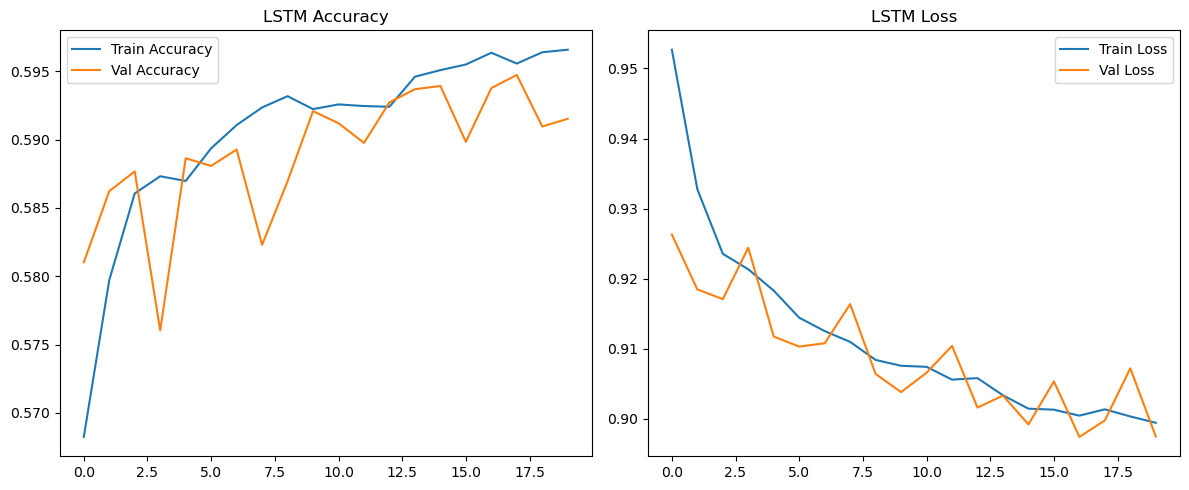

390/390 [==============================] - 0s 865us/step - loss: 0.8969 - accuracy: 0.5964
LSTM Test Accuracy: 0.5964

Training LSTM_Attention...
Epoch 1/100
910/910 [==============================] - 3s 2ms/step - loss: 0.9492 - accuracy: 0.5715 - val_loss: 0.9209 - val_accuracy: 0.5813
Epoch 2/100
910/910 [==============================] - 1s 1ms/step - loss: 0.9280 - accuracy: 0.5823 - val_loss: 0.9271 - val_accuracy: 0.5839
Epoch 3/100
910/910 [==============================] - 1s 1ms/step - loss: 0.9210 - accuracy: 0.5853 - val_loss: 0.9180 - val_accuracy: 0.5838
Epoch 4/100
910/910 [==============================] - 1s 1ms/step - loss: 0.9188 - accuracy: 0.5864 - val_loss: 0.9272 - val_accuracy: 0.5855
Epoch 5/100
910/910 [==============================] - 1s 1ms/step - loss: 0.9142 - accuracy: 0.5896 - val_loss: 0.9052 - val_accuracy: 0.5905
Epoch 6/100
910/910 [==============================] - 1s 1ms/step - loss: 0.9119 - accuracy: 0.5900 - val_loss: 0.9063 - val_accuracy: 0.5

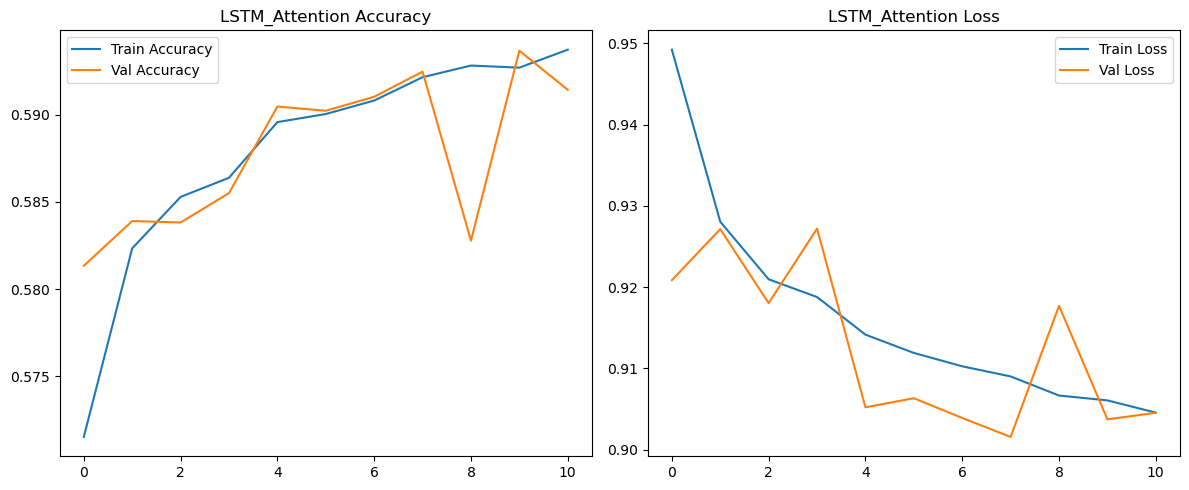

390/390 [==============================] - 0s 759us/step - loss: 0.9017 - accuracy: 0.5940
LSTM_Attention Test Accuracy: 0.5940

Training GRU...
Epoch 1/100
910/910 [==============================] - 3s 2ms/step - loss: 0.9619 - accuracy: 0.5630 - val_loss: 0.9307 - val_accuracy: 0.5798
Epoch 2/100
910/910 [==============================] - 2s 2ms/step - loss: 0.9317 - accuracy: 0.5808 - val_loss: 0.9274 - val_accuracy: 0.5834
Epoch 3/100
910/910 [==============================] - 2s 2ms/step - loss: 0.9243 - accuracy: 0.5861 - val_loss: 0.9290 - val_accuracy: 0.5801
Epoch 4/100
910/910 [==============================] - 2s 2ms/step - loss: 0.9208 - accuracy: 0.5867 - val_loss: 0.9104 - val_accuracy: 0.5903
Epoch 5/100
910/910 [==============================] - 2s 2ms/step - loss: 0.9172 - accuracy: 0.5888 - val_loss: 0.9134 - val_accuracy: 0.5880
Epoch 6/100
910/910 [==============================] - 2s 2ms/step - loss: 0.9145 - accuracy: 0.5908 - val_loss: 0.9106 - val_accuracy: 0.58

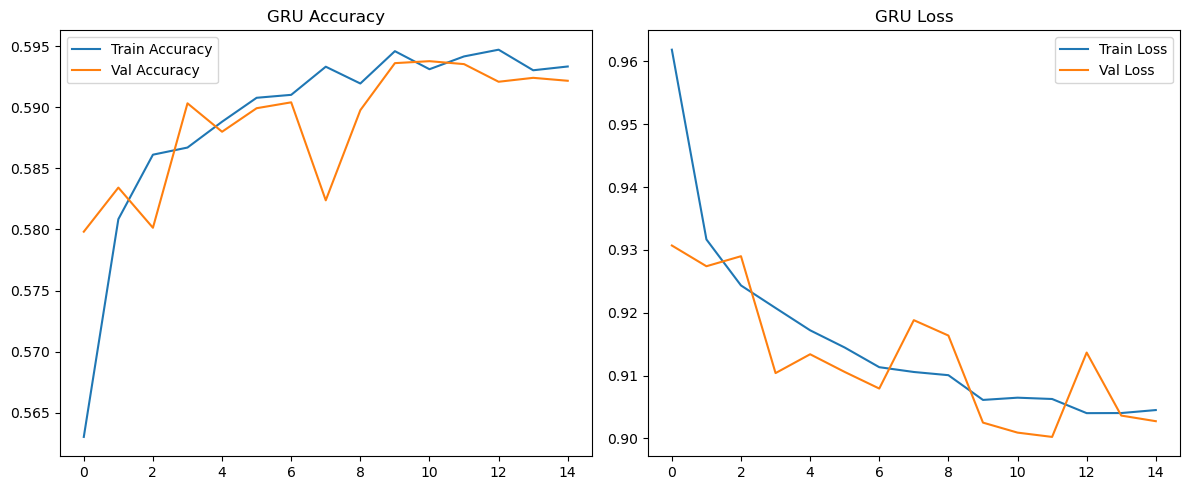

390/390 [==============================] - 0s 833us/step - loss: 0.8991 - accuracy: 0.5981
GRU Test Accuracy: 0.5981

Training Transformer...
Epoch 1/100
910/910 [==============================] - 5s 4ms/step - loss: 1.0084 - accuracy: 0.5471 - val_loss: 0.9253 - val_accuracy: 0.5809
Epoch 2/100
910/910 [==============================] - 2s 2ms/step - loss: 0.9288 - accuracy: 0.5818 - val_loss: 0.9643 - val_accuracy: 0.5711
Epoch 3/100
910/910 [==============================] - 2s 2ms/step - loss: 0.9222 - accuracy: 0.5858 - val_loss: 0.9374 - val_accuracy: 0.5844
Epoch 4/100
910/910 [==============================] - 8s 8ms/step - loss: 0.9158 - accuracy: 0.5901 - val_loss: 0.9076 - val_accuracy: 0.5906
Epoch 5/100
910/910 [==============================] - 2s 2ms/step - loss: 0.9139 - accuracy: 0.5911 - val_loss: 0.9298 - val_accuracy: 0.5881
Epoch 6/100
910/910 [==============================] - 2s 2ms/step - loss: 0.9112 - accuracy: 0.5910 - val_loss: 0.9146 - val_accuracy: 0.5922


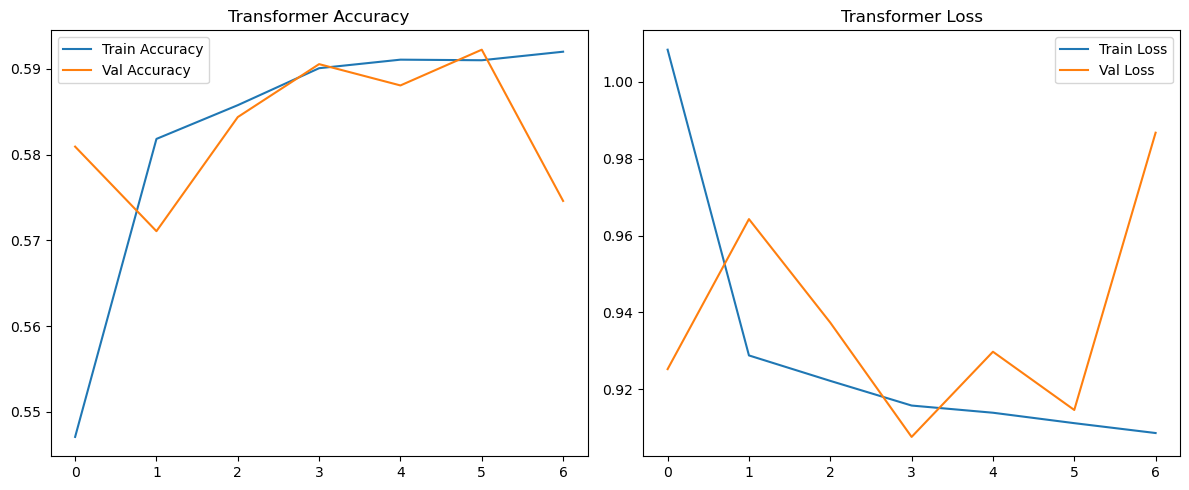

390/390 [==============================] - 0s 929us/step - loss: 0.9066 - accuracy: 0.5925
Transformer Test Accuracy: 0.5925


In [67]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

def train_and_evaluate(model, model_name, X_train_model, X_val_model, X_test_model):
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    checkpoint = ModelCheckpoint(f'best_{model_name}.h5', save_best_only=True)
    
    history = model.fit(
        X_train_model, y_train,
        validation_data=(X_val_model, y_val),
        epochs=100,
        batch_size=64,
        callbacks=[early_stop, checkpoint]
    )
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Evaluate
    test_loss, test_acc = model.evaluate(X_test_model, y_test)
    print(f'{model_name} Test Accuracy: {test_acc:.4f}')
    return test_acc

# Verify label shapes
print(f"Label shapes - y_train: {y_train.shape}, y_val: {y_val.shape}, y_test: {y_test.shape}")

# Reshape data for sequence models
X_train_3d = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val_3d = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test_3d = X_test.reshape((X_test.shape[0], 1, X_train.shape[1]))

# Initialize models with corrected architectures
num_classes = 3
models = {
    'LSTM': (build_lstm((1, X_train.shape[1]), num_classes), X_train_3d, X_val_3d, X_test_3d),
    'LSTM_Attention': (build_lstm_attention((1, X_train.shape[1]), num_classes), X_train_3d, X_val_3d, X_test_3d),
    'GRU': (build_gru((1, X_train.shape[1]), num_classes), X_train_3d, X_val_3d, X_test_3d),
    'Transformer': (build_transformer((1, X_train.shape[1]), num_classes), X_train_3d, X_val_3d, X_test_3d)
}

# Train and compare models
results = {}
for name, (model, X_tr, X_v, X_te) in models.items():
    print(f"\nTraining {name}...")
    results[name] = train_and_evaluate(model, name, X_tr, X_v, X_te)

## Step 4: Model Saving & Prediction


In [68]:
import joblib
import tensorflow as tf
from tensorflow import keras

# Ensure `best_model` is a Keras model (not a tuple)
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]

# If `models[best_model_name]` is a tuple, extract the model
if isinstance(best_model, tuple):
    best_model = best_model[0]  # Assuming the first element is the Keras model

# Save the model
model_path = f'arabic_sentiment_{best_model_name}.h5'
best_model.save(model_path)
print(f"Best model saved as: {model_path}")

# Save the label encoder
# joblib.dump(le, 'label_encoder.pkl')
print("Label encoder saved as: label_encoder.pkl")



Best model saved as: arabic_sentiment_GRU.h5
Label encoder saved as: label_encoder.pkl


Confusion matrix & classification report

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(model, X_test, y_test, label_mapping):
    """
    Displays the confusion matrix for the best-performing model.

    Args:
        model (keras.Model): The trained sentiment analysis model.
        X_test (numpy.ndarray): Test data (embeddings).
        y_test (numpy.ndarray): True labels.
        label_mapping (dict): Dictionary mapping label names to indices.
    """
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)  # Convert softmax outputs to class indices

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred_labels)
    
    # Decode class labels
    class_names = list(label_mapping.keys())  # Get original class names
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_labels, target_names=class_names))




390/390 [==============================] - 1s 880us/step


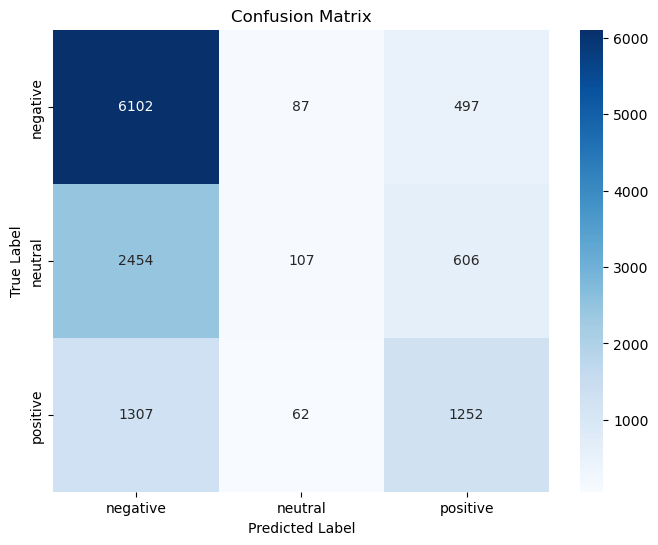


Classification Report:
              precision    recall  f1-score   support

    negative       0.62      0.91      0.74      6686
     neutral       0.42      0.03      0.06      3167
    positive       0.53      0.48      0.50      2621

    accuracy                           0.60     12474
   macro avg       0.52      0.47      0.43     12474
weighted avg       0.55      0.60      0.52     12474



: 

In [74]:
# Reshape X_test to match the expected input shape
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# plot confusion matrix
plot_confusion_matrix(best_model, X_test_reshaped, y_test, label_mapping)